In [71]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [72]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

--2022-12-12 13:02:34--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   199MB/s    in 0.3s    

2022-12-12 13:02:35 (199 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [73]:

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)]) # 2001
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)]) # 1001
total_test = len(os.listdir(test_dir)) # 51

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [74]:
# 3
# EXAMPLE: see "Example of using .flow_from_directory(directory):" in 
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# EXAMPLE 2: see "classifier_from_little_data_script_1.py" in
#https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d?utm_source=www.tensorflow.org&utm_medium=referral

# 3.1. Create image generators for each of the three image data sets 
#(train, validation, test). Use ImageDataGenerator to read / decode 
#the images and convert them into floating point tensors. Use the 
#rescale argument (and no other arguments for now) to rescale the 
#tensors from values between 0 and 255 to values between 0 and 1.

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# 3.2. For the *_data_gen variables, use the flow_from_directory method. 
#Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)), 
#class mode, and anything else required. test_data_gen will be the trickiest 
#one. For test_data_gen, make sure to pass in shuffle=False to the 
#flow_from_directory method. This will make sure the final predictions stay 
#is in the order that our test expects. For test_data_gen it will also be 
#helpful to observe the directory structure.

#flow_from_directory(
#    directory,
#    target_size=(256, 256),
#    color_mode='rgb',
#    classes=None,
#    class_mode='categorical',
#    batch_size=32,
#    shuffle=True,
#    seed=None,
#    save_to_dir=None,
#    save_prefix='',
#    save_format='png',
#    follow_links=False,
#    subset=None,
#    interpolation='nearest',
#    keep_aspect_ratio=False
#)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size, class_mode='binary',
    #classes=['cats', 'dogs']
)
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size, class_mode='binary',
    #classes=['cats', 'dogs']
)
test_data_gen = test_image_generator.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size, class_mode='binary',
    classes=[''], shuffle=False
)

# After you run the code, the output should look like this:
#Found 2000 images belonging to 2 classes.
#Found 1000 images belonging to 2 classes.
#Found 50 images belonging to 1 class.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


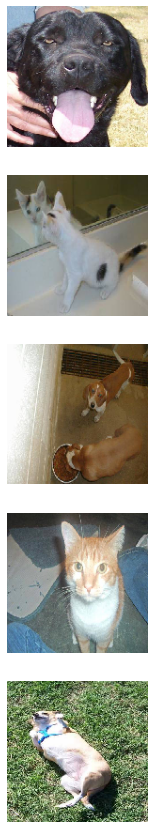

In [75]:
# 4

# The plotImages function will be used a few times to plot images. It takes an 
#array of images and a probabilities list, although the probabilities list is 
#optional. This code is given to you. If you created the train_data_gen variable 
#correctly, then running this cell will plot five random training images.

def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, ax, probability in zip( images_arr, axes, probabilities):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [76]:
# 5

# Recreate the train_image_generator using ImageDataGenerator.

# Since there are a small number of training examples, there is a risk of 
#overfitting (not having enought training data). One way to fix this problem 
#is by creating more training data from existing training examples by using 
#random transformations.

# Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure 
#to rescale the same as before.

train_image_generator = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.01,
    height_shift_range=0.01,
    rotation_range=30,
    zoom_range=0.2,
    #shear_range=20.0,
    brightness_range=(0.40,0.80),
    channel_shift_range=30.0,
    horizontal_flip=True
    #vertical_flip=True,
)

# Arguments examples explained: 
#https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

Found 2000 images belonging to 2 classes.


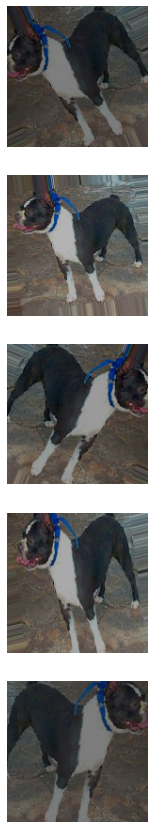

In [77]:
# 6

# You don't have to do anything for this cell. train_data_gen is created just 
#like before but with the new train_image_generator. Then, a single image is 
#plotted five different times using different variations.

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
# PERSONAL NOTE: train_data_gen receives 16 batches of batch_size=128 images
#(previously defined), each image with a shape of 150x150 (height x width) and 
#3 channels.

# train_data_gen[0][0][0] means first image of the training images 
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [86]:
print(train_data_gen[0][0].shape)
print(train_data_gen.n)
print(train_data_gen.labels)

# create augmented images
#augmented_train_images = [ train_data_gen[0][0][i] for i in range(train_data_gen.n) for _ in range(5) ]
# create augmented images's labels
#_, train_labels = next(train_data_gen)
#augmented_train_labels = [ train_labels[i] for i in range(train_data_gen.n) for _ in range(5) ]

#print(len(augmented_train_images))
#print(len(augmented_train_labels))

(128, 150, 150, 3)

In [78]:
# 7

# 7.1. In this cell, create a model for the neural network that outputs class 
#probabilities. It should use the Keras Sequential model. It will probably 
#involve a stack of Conv2D and MaxPooling2D layers...

# Create Keras Sequential Model
model = Sequential()

# Build Convolutional Base (a stack of Conv2D and MaxPooling2D layers)
model.add( Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) )
model.add( MaxPooling2D(pool_size=(2, 2)) )

model.add( Conv2D(32, (3, 3), activation='relu') )
model.add( MaxPooling2D(pool_size=(2, 2)) )

model.add( Conv2D(64, (3, 3), activation='relu') )
model.add( MaxPooling2D(pool_size=(2, 2)) )
# PERSONAL NOTE: These two type of layers (convolutional and MaxPooling) will
#extract the features from the image.
#Going to process 32 filters of size 3x3 over the input shape 
#of the data, which is (height, width, channels) = (150, 150, 3).
#Then, will perform the max pooling operation using 2x2 samples and a stride 
#of 2 (if strides=None (default), it will default to pool_size).

#model.summary()
# PERSONAL OBSERVATION: After looking at the summary it's worth noting that 
#the depth (frequency of filters) of our image increases but the spacial 
#dimensions (height and width) reduce (shrinks) drastically.

In [79]:
# 7.2. ... and then [involve] a fully connected layer on top that is activated by a ReLU 
#activation function.

model.add( Flatten() )
model.add( Dense(64, activation='relu') )
model.add( Dropout(0.5) )
model.add( Dense(1, activation='sigmoid') )
# PERSONAL NOTE: Then these extracted features (after finishing the convolutional 
#base) are flattened and fed to densely connected layers that determine the class
#of an image based on the presence of features.
# The Flatten layer changes the shape of the data as to feed it to 
#the 64-node dense layer, followed by the final output layer of 2
#neurons (one for each class: 'cats' and 'dogs').

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [80]:
# 7.3. Compile the model passing the arguments to set the optimizer and loss. Also 
#pass in metrics=['accuracy'] to view training and validation accuracy for each 
#training epoch.

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# More on built-in loss functions:
#https://www.tensorflow.org/api_docs/python/tf/keras/losses

In [81]:
# 8

# Use the fit method on your model to train the network. Make sure to pass in 
#arguments for x, steps_per_epoch, epochs, validation_data, and validation_steps.

history = model.fit(
    train_data_gen,
    epochs=epochs, steps_per_epoch=train_data_gen.n // batch_size,
    validation_data=val_data_gen, validation_steps=val_data_gen.n // batch_size,
    verbose=1
)

# More on fit method:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#verbose -> 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 
#2 = one line per epoch

Epoch 1/15
15/15 [==============================] - 50s 3s/step - loss: 0.7722 - accuracy: 0.5048 - val_loss: 0.6859 - val_accuracy: 0.5011
Epoch 2/15
15/15 [==============================] - 46s 3s/step - loss: 0.6893 - accuracy: 0.5347 - val_loss: 0.6759 - val_accuracy: 0.5982
Epoch 3/15
15/15 [==============================] - 46s 3s/step - loss: 0.7026 - accuracy: 0.5427 - val_loss: 0.6673 - val_accuracy: 0.5592
Epoch 4/15
15/15 [==============================] - 48s 3s/step - loss: 0.6781 - accuracy: 0.5726 - val_loss: 0.7227 - val_accuracy: 0.5145
Epoch 5/15
15/15 [==============================] - 46s 3s/step - loss: 0.6728 - accuracy: 0.5865 - val_loss: 0.6320 - val_accuracy: 0.6484
Epoch 6/15
15/15 [==============================] - 46s 3s/step - loss: 0.6736 - accuracy: 0.6106 - val_loss: 0.6202 - val_accuracy: 0.6652
Epoch 7/15
15/15 [==============================] - 47s 3s/step - loss: 0.6455 - accuracy: 0.6437 - val_loss: 0.6035 - val_accuracy: 0.6830
Epoch 8/15
15/15 [==

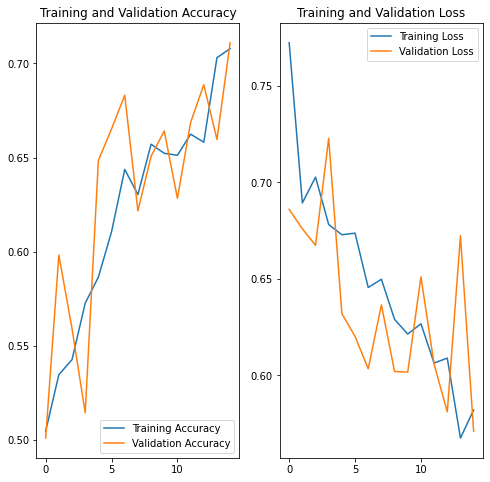

In [82]:
# 9

# Run this cell to visualize the accuracy and loss of the model.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

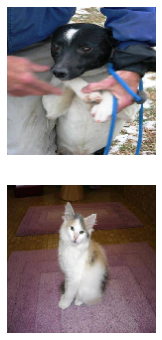

2/2 [==============================] - 0s 96ms/step
[[0.69987   ]
 [0.45278844]
 [0.02263627]
 [0.8830109 ]
 [0.29087564]
 [0.6820625 ]
 [0.802004  ]
 [0.25725466]
 [0.72152585]
 [0.99469745]
 [0.28576759]
 [0.6665557 ]
 [0.3173762 ]
 [0.35566038]
 [0.5311104 ]
 [0.59495765]
 [0.6527842 ]
 [0.9203384 ]
 [0.7778041 ]
 [0.82163304]
 [0.01883731]
 [0.842548  ]
 [0.3111112 ]
 [0.60796124]
 [0.8769577 ]
 [0.3994586 ]
 [0.9258387 ]
 [0.2455094 ]
 [0.38888574]
 [0.65213096]
 [0.14390677]
 [0.28757834]
 [0.85794604]
 [0.9999997 ]
 [0.28645614]
 [0.5183685 ]
 [0.9999334 ]
 [0.6955216 ]
 [0.48889259]
 [0.53747827]
 [0.44641653]
 [0.4512121 ]
 [0.9858779 ]
 [0.8475063 ]
 [0.86289966]
 [0.61034745]
 [0.5479862 ]
 [0.0730044 ]
 [0.24216609]
 [0.06813382]]


In [83]:
# 10

# Now it is time to use your model to predict whether a brand new image is a cat 
#or a dog.

# In this cell, get the probability that each test image (from test_data_gen) is 
#a dog or a cat. probabilities should be a list of integers.

train_images, train_labels = next(train_data_gen)
val_images, val_labels = next(val_data_gen)
test_images, _ = next(test_data_gen)
plotImages(test_images[:2])
#print(train_labels)

probabilities = model.predict(test_data_gen[0][0])
probabilities = np.reshape( np.round(probabilities), newshape=(50) ).tolist()
print(probabilities)
#plotImages(test_images, probabilities)

#augmented_images = [train_data_gen[0][0][0] for i in range(5)]
#plotImages(augmented_images)

# Call the plotImages function and pass in the test images and the probabilities 
#corresponding to each test image.
plotImages(test_data_gen[0][0], probabilities)

# After you run the cell, you should see all 50 test images with a label showing 
#the percentage of "sure" that the image is a cat or a dog. The accuracy will 
#correspond to the accuracy shown in the graph above (after running the previous 
#cell). More training images could lead to a higher accuracy.

In [84]:
#print(test_data_gen.n)
#print(test_data_gen.labels)
#print(test_images.shape)
#print(probabilities)
#print(probabilities.shape)
#print(test_images[0])
#print(test_data_gen[0][0].shape)
#dir(test_data_gen)

[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


In [85]:
# 11

# Run this final cell to see if you passed the challenge or if you need to keep 
#trying.

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
